In [1]:
import depth_transformations as dt
from scipy.spatial.transform import Rotation as R
import numpy as np
from PIL import Image
import cv2
from rich.traceback import install as install_rich
import json
from matplotlib import pyplot as plt
import open3d as o3d
install_rich()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f3f0cc3fd90>>

In [2]:
%matplotlib notebook
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
plt.rcParams['figure.figsize'] = 10, 20

#### Helpers and Plotters

In [3]:
def two_plot(im0, im1, label0="", label1=""):
    plt.subplot(1, 2, 1)
    plt.title(label0)
    plt.imshow(im0)
    plt.subplot(1, 2, 2)
    plt.title(label1)
    plt.imshow(im1)
    plt.show()

In [4]:
def check_values(a,name=""):
    if name: print(name)
    print(f"min: {a.min()}, mean: {a.mean()}, max: {a.max()}")

### Constants and Settings

In [5]:
# Constnats and paths
SCENE = 'intrinsic_tester_sphere'
SPLIT = ''
DATASET_PATH = "/home/dtetruash/Thesis/datasets/nerf-blender/nerf_synthetic"
SCENE_PATH = f"{DATASET_PATH}/{SCENE}"
DATA_PATH = f"{SCENE_PATH}/{SPLIT}" if SPLIT else SCENE_PATH

LIGHTS_FILE = f"{SCENE_PATH}/lights_{SCENE}_bottom.json"
TRANSFORMS_FILE = f"{SCENE_PATH}/transforms_{SPLIT}.json" if SPLIT else f"{SCENE_PATH}/transforms.json"

IMAGE_NUMBER = 0

###  Loading Images & Transforms

In [6]:
# Load Transforms
with open(TRANSFORMS_FILE, 'r') as tf:
    image_transforms = json.loads(tf.read())

In [7]:
# Get the transform for the given image
def get_c2w(image_number):
    return np.array(image_transforms['frames'][image_number]['transform_matrix'])

# Transfomation matrix functions
def to_translation(c2w):
    return c2w[:3, -1]

def to_rotation(c2w):
    return c2w[:3,:3]


In [8]:
# Image loading functions
def get_image_name(image_number, channel=""):
    return f"{DATA_PATH}/r_{image_number:03d}{f'_{channel}' if channel else ''}.png"

def get_image(image_number, channels=[], open_func=Image.open):
    """Get an image along with it's given channels."""
    images = {'combined': get_image_name(image_number)}
    images.update({channel: get_image_name(image_number, channel) for channel in channels})
    return {k: open_func(v) for (k, v) in images.items()}


def remap_depth_black2white(depth_array):
    """Remap an 8-bit depth image where 255 -> near and 0 -> far
    to the convention that 0 -> near and 255 -> far.
    """
    return -depth_array + 255

In [11]:
# Get needed image passes
images = get_image(IMAGE_NUMBER, ['albedo', 'depth', 'normal', 'diffuse'])


In [12]:
get_image_name(0)

'/home/dtetruash/Thesis/datasets/nerf-blender/nerf_synthetic/intrinsic_tester_sphere/r_000.png'

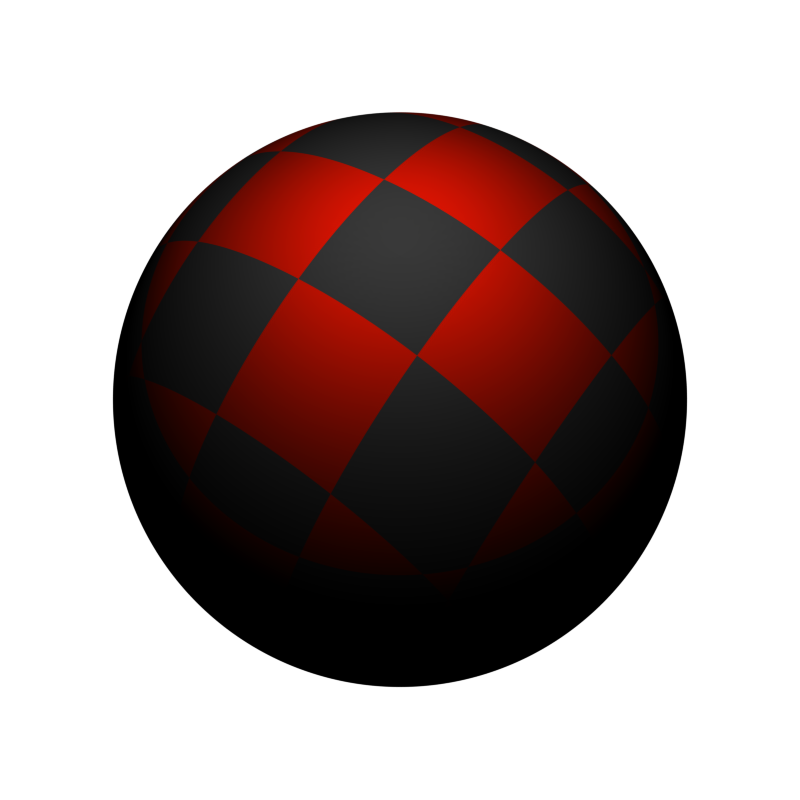

In [15]:
#images['combined']=  Image.open("/home/dtetruash/Thesis/datasets/nerf-blender/nerf_synthetic/intrinsic_tester_sphere/r_000_diffuse_bottom.png")
images['combined']

In [16]:
def read_16bit(img_name):
    """Read a 16-bit PNG into a numpy array"""
    bgrd = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
    rgbd = np.empty_like(bgrd)
    rgbd[...,:3] = np.flip(bgrd[...,:3], axis=2)
    rgbd[...,-1] = bgrd[...,-1]
    return rgbd


In [17]:
# Read normal as a 16-bit image
image_normal = read_16bit(get_image_name(IMAGE_NUMBER, channel='normal'))

check_values(image_normal)
image_normal.shape, image_normal.dtype

min: 0, mean: 19144.70401640625, max: 65535


((800, 800, 4), dtype('uint16'))

In [ ]:
check_values((image_normal / float((2**16 - 1)))[...,:3])
plt.imshow((image_normal / float((2**16 - 1))))

In [ ]:
# Reloading to meet the RGBd creation function requirements on image channels
image_combined_rgb = o3d.geometry.Image(np.asarray(images['combined'].convert("RGB")))
plt.imshow(image_combined_rgb)

In [ ]:
# invert the depth image
depth_raw = remap_depth_black2white(np.asarray(images['depth'])[:, :, -1].astype(np.uint8))
image_depth = o3d.geometry.Image(depth_raw)

In [ ]:
print("Loaded RAW images.")
two_plot(
    np.asarray(images['combined']),
    np.asarray(images['depth']),
    label0="combined image",
    label1="depth image")

In [ ]:
print("Images with correct channels")
two_plot(image_combined_rgb, image_depth, label0="combined RGB image", label1="scalar depth image")

### Lights and Light Transforms

In [ ]:
# Get lights information
with open(LIGHTS_FILE, 'r') as lf:
    lights_info = json.loads(lf.read())
f"Number of lights {len(lights_info['lights'])}"

In [ ]:
# Get the location of the lights
light_transforms = [np.array(light['transformation_matrix']) for light in lights_info['lights']]
light_locations = [to_translation(transform) for transform in light_transforms]
light_locations

### Camera Parameters and Rays

In [ ]:
# Pinhole camera functions
image_combined_array = np.asarray(images['combined'])
H, W = image_combined_array.shape[:-1]
# H = W = 100

def get_focal(width, camera_angle_x):
    return .5 * width / np.tan(.5 * camera_angle_x)

def get_rays(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera.
    Taken from https://github.com/bmild/nerf/blob/master/run_nerf_helpers.py#L133C1-L140C26"""
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    return rays_o, rays_d

In [ ]:
focal = get_focal(W, image_transforms["camera_angle_x"])
focal

In [ ]:
c2w = get_c2w(IMAGE_NUMBER)
c2w

In [ ]:
T = to_translation(c2w)
R = to_rotation(c2w)
print(R); print(T.T[...,np.newaxis])

In [ ]:
ray_o, rays_d = get_rays(H, W, focal, c2w)
rays_d.shape

## Creating Point Cloud

### Using Depth Projection

In [ ]:
def denormalize_depth(depth_image_array, from_min=0, from_max=8):
    """Inverse the depth image mapping which we did in blender during compositing.
    The default forrward mapping is (0,8) -> (1,0).
    Return depth of each pixel in """
    depth_from_alpha = depth_image_array[..., -1]
    return (depth_from_alpha/255. - 1) * -(from_max - from_min), depth_from_alpha > 0

In [ ]:
#%%script echo skipping
depth_vals, depth_mask = denormalize_depth(np.asarray(images['depth']))
num_points = depth_mask.sum()
print(f"There are {num_points} points with finite depth in the image")

In [ ]:
%%script echo skipping
two_plot(
    depth_vals/8,
    depth_mask,
    label0="depth mapped",
    label1="depth mask")


In [ ]:
%%script echo skipping
# Compute point cloud!
# 1. Compute the distances along the rays from camera to the z-depth values
# Project the vector direction onto the world-space optical axis
# scale the direciton vector by the depth/projection factor

optical_axis = np.array([0,0,-1])
world_optical_axis = c2w[:3, :3] @ optical_axis
optical_axis, world_optical_axis, np.linalg.norm(world_optical_axis)

In [ ]:
%%script echo skipping
# Project the rays onto the optical axis. If rays lie on z=1,
# then all projections should be equal  to 1
f_factors =  rays_d[...,None,:] @ np.broadcast_to(world_optical_axis, rays_d.shape)[...,None]
np.all(np.abs((f_factors[...,0,0] - 1 )) < 1e-6) # All f-factors are equal to 1 upto precision

In [ ]:
%%script echo skipping
# if the factor is 1, then all we must do is scale all directions by their depth value in those locations where there is depth

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim3d(1, 3)
ax.set_ylim3d(2, 4)
ax.set_zlim3d(-2.5, -0.5)

data = depth_vals[depth_mask, np.newaxis] * rays_d[depth_mask]

ax.scatter([0], [0], [0], c='red') # Camera point
ax.scatter(data[:,0], data[:,1], data[:,2],c=-depth_vals[depth_mask], cmap=plt.gray(), marker=',')

### Using Open3D RGBD + Point Cloud

In [ ]:
#o3d.geometry.RGBDImage.create_from_color_and_depth?

In [ ]:
np.asarray(image_combined_rgb).shape

In [ ]:
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_combined_rgb, image_depth,
    depth_scale=1/8, depth_trunc=8,
    convert_rgb_to_intensity=False)

In [ ]:
image_depth

In [ ]:
two_plot(
    rgbd_image.color,
    rgbd_image.depth,
    label0='RGBD Color', label1='RGBD Depth')

In [ ]:
# Set intrinsic matrix
f_x = f_y = focal
# f_y = 1666.6666
intrinsics = o3d.camera.PinholeCameraIntrinsic(W, H, f_x, f_y, W/2., H/2.)
print("K = ")
print(intrinsics.intrinsic_matrix)

In [ ]:
#r = R.from_euler('x', 90, degrees=True)

In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(intrinsics)
)
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
# pcd.rotate(r.as_matrix())

In [ ]:
points = np.asarray(pcd.points)

In [ ]:
num_points == points.shape[0]

In [ ]:
#%%script echo skipping
o3d.visualization.draw_geometries([pcd], mesh_show_back_face=False)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_aspect('equal', 'box')
ax.set_title("Open3D Point Cloud (Unposed)")
# ax.scatter([0], [0], [0], c='red') # Camera point
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=-depth_vals[depth_mask], cmap=plt.gray(), marker=',')

In [ ]:
# Pose the point cloud with the camera transform
pcd.transform(c2w)
points_posed = np.asarray(pcd.points)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_aspect('equal', 'box')
ax.set_title("Open3D Point Cloud (Posed)")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(0,2)
# ax.scatter([0], [0], [0], c='red') # Camera point
ax.scatter(light_locations[0][0], light_locations[0][1], light_locations[0][2], c='red')
ax.scatter(points_posed[:, 0], points_posed[:, 1], points_posed[:, 2], c=-depth_vals[depth_mask], cmap=plt.gray(), marker=',')

### Using Partha's Projection Code

In [ ]:
# TODO:
# 1. Get the camera matrices for each image.
#    a. Use the transform provided. (It is just the extrinsics, in the blender convention)
# use the intrinsics found earlier (f_y=f_x=1111px, 400,400)

In [ ]:
np.set_printoptions(suppress=True)
print("K = ")
print(intrinsics.intrinsic_matrix)

In [ ]:
pcd_partha = dt.depth2pcd_posed(
    np.asarray(rgbd_image.depth),
    np.asarray(rgbd_image.color),
    intrinsics.intrinsic_matrix,
    c2w)

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

In [ ]:
#r = R.from_euler('x', 90, degrees=True)
# pcd_partha.rotate(r.as_matrix())

In [ ]:
%%script echo skipping
o3d.visualization.draw_geometries([pcd_partha], mesh_show_back_face=True)

In [ ]:
%%script echo skipping
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pcd_partha_array = np.asarray(pcd_partha.points)

ax.set_aspect('equal', 'box')
ax.scatter([0], [0], [0], c='red')  # Camera point
ax.scatter(pcd_partha_array[:, 0], pcd_partha_array[:, 1], pcd_partha_array[:, 2], cmap=plt.gray(), marker=',')

## Raster Rendering

In [ ]:
# Compute the OLAT samples for the scene

# Constants and containers for later
POINT_SOURCE_POWER = 30

raster_image = np.zeros((W, H, 3))

In [ ]:
### Check the rotation matrix
print(f"det(R) = {np.linalg.det(R)}")
print("R^T @ R =")
Rt_R = R.T @ R
print(Rt_R)

### Load camera-space normals and scale them to the correct ranges 

In [ ]:
camera_normals_pixels = (image_normal[...,:-1] / (2**16 - 1))
for i in range(camera_normals_pixels.shape[-1]):
    check_values(camera_normals_pixels[depth_mask][...,i], name=f"Camera-space Normals {i}")

In [ ]:
# Translation and scaling needed to remap to [-1,1], [-1,1], and [-1,0] resp.
normals_shift = np.array([-0.5]*3)
normals_scale = np.array([2.0]*3)
#normals_scale[-1] *= -1
normals_shift, normals_scale

In [ ]:
camera_normals = (camera_normals_pixels + normals_shift) * normals_scale

In [ ]:
for i in range(camera_normals.shape[-1]):
    check_values(camera_normals[depth_mask][...,i], name=f"Camera-space Normals {i}")

In [ ]:
# Check the norms of the normals
camera_normals_norms = np.linalg.norm(camera_normals, axis=2)
camera_normals_norms.shape

In [ ]:
check_values(camera_normals_norms[depth_mask], name="Camera Normals Norms")

In [ ]:
# Normalize the normals
camera_normals_normalized = camera_normals / camera_normals_norms[...,np.newaxis] * depth_mask[...,np.newaxis]

In [ ]:
check_values(np.linalg.norm(camera_normals_normalized[depth_mask], axis=1))

#### Get World Normals

In [ ]:
# Reshape the vectors to be a list of 3D points
camera_normals_flattened = camera_normals_normalized.reshape(-1, 3).T
camera_normals_flattened.shape  # Column vectors per image pixel

In [ ]:
# Transform the vectors to world space
world_normals_flattened = np.dot(R, camera_normals_flattened)

In [ ]:
# Reshape the transformed vectors back to the original image shape
world_normals = world_normals_flattened.T.reshape(camera_normals.shape)
world_normals.shape

### Validate by adding normals to point cloud

In [ ]:
pcd.normals = o3d.utility.Vector3dVector(world_normals[depth_mask])
pcd.normals

In [ ]:
#%%script echo skipping
o3d.visualization.draw_geometries([pcd])

#### Get Light Distances for First Light

In [ ]:
light_vectors = np.zeros_like(raster_image)
light_vectors[depth_mask] = light_locations[0] - points_posed
plt.imshow(light_vectors)

In [ ]:
# Get norms of the light vectors
light_norms = np.zeros(raster_image.shape[:-1])
light_norms[depth_mask] = np.linalg.norm(light_vectors[depth_mask], axis=1)
light_norms_sqr = np.square(light_norms)
light_norms.shape, light_norms_sqr.shape

In [ ]:
# Should have higher values at the bottom
plt.imshow(light_norms)

In [ ]:
# Normalized light vectors
light_vectors[depth_mask] = light_vectors[depth_mask] / light_norms[depth_mask][...,np.newaxis]

In [ ]:
# Compute dots
normal_dot_light = np.zeros(raster_image.shape[:-1])
normal_dot_light = np.sum(world_normals.reshape((-1, 3)) * light_vectors.reshape((-1, 3)), axis=1)

normal_dot_light = np.maximum(normal_dot_light.reshape((W, H)), 0) * depth_mask
plt.imshow(normal_dot_light, cmap=plt.gray())

In [ ]:
# Compute reaster image
albedo = np.asarray(images['albedo'])[:, :, :3].astype(np.float32) / 255.
normal_dot_light = normal_dot_light / normal_dot_light.max()

In [ ]:
raster_image = albedo * normal_dot_light[:, :, np.newaxis]

In [ ]:
plt.imshow(normal_dot_light / (light_norms_sqr + 1e-5))

In [ ]:
check_values(raster_image)
check_values(albedo)
check_values(normal_dot_light)

In [ ]:
check_values(raster_image, name='Raster')

In [ ]:
two_plot(raster_image, albedo, label0="raster", label1="albedo")

In [ ]:
raster_image_vis = raster_image.copy()
raster_image_vis[~depth_mask] = 1

In [ ]:
two_plot(raster_image_vis, np.asarray(images['combined']), label0="raster", label1="GT (with denoising)")

In [ ]:
plt.imsave('raster.png', raster_image_vis)

In [ ]:
plt.imshow(np.abs(raster_image - np.asarray(images['combined'])[...,:-1]))

In [ ]:
{(channel:=f"channel_{n}"): channel.upper() for n in [1,2,3]}